# Hierarchical Clustering

We will look at clustering using hierarchical clustering (also known as agglomerative clustering).

Hierarchical clustering starts by assigning each datapoint to a unique cluster. The algorithm then merges clusters to form bigger clusters, using some rule to decide which clusters are "close" to one another and thus should be merged. The algorithm repeats until there is one supercluster containing all data, but within the cluster are smaller clusters with greater granularity.

Choosing the number of clusters to use amounts to how far to traverse down the hierarchical tree grouping data points together.

## Aside: Similarity Scores

Hierarchical clustering works by grouping "similar" data points together. This requires computing what are known as similarity scores. When two data points are very similar this score is high, while if two are very dissimilar this score is low.

We will be computing similarity scores for the article titles in `HNHeadlines.txt` (consisting of titles of posts to [Hacker News](https://news.ycombinator.com/)). I load in that dataset as a Series below.

In [1]:
import pandas as pd

In [2]:
headlines = pd.read_csv("HNHeadlines.txt", header=None, index_col=0).iloc[:, 0]
headlines

0
0      Uber Co-Founder Travis Kalanick Said to Plan S...
1                         Update on Meltdown and Spectre
2      Intel Issues Updates to Protect Systems from S...
3       Where Pot Entrepreneurs Go When the Banks Say No
4                      Announcing the OpenWrt/LEDE merge
5                 Transpile Java Bytecode to WebAssembly
6                                     iMac Pro's T2 chip
7      Productivity in 2017: analyzing 225 million ho...
8      About speculative execution vulnerabilities in...
9      “My ten hour white noise video now has five co...
10                Site Isolation – The Chromium Projects
11     Xerox Alto zero-day: cracking disk password pr...
12                     The Best Things and Stuff of 2017
13     More details about mitigations for the CPU Spe...
14                     In pursuit of Otama's tone (2017)
15            Show HN: PAST, a secure alternative to JWT
16     Ink/stitch: an Inkscape extension for machine ...
17     Texttop – An interacti

In natural language processing, a $n$-gram is $n$ characters that appear in sequence in a string. For example, all 3-grams of the word "library" are `lib`, `ibr`, `bra`, `rar`, and `ary`. These are often used to generate a feature space from a string based on its contents.

I use [NLTK](http://www.nltk.org/) (Natural Language Tool Kit, a Python library for natural language processing) to form 3-grams for every headline in this dataset. (I require all words be lower-case but do not remove non-alphanumeric characters.)

In [3]:
from nltk import ngrams

In [4]:
headline_sets = [set(''.join(u) for u in ngrams(h.lower(), 3)) for h in headlines]
headline_sets[:3]

[{' 29',
  ' co',
  ' ka',
  ' of',
  ' pl',
  ' sa',
  ' st',
  ' to',
  ' tr',
  '% o',
  '-fo',
  '29%',
  '9% ',
  'aid',
  'ake',
  'ala',
  'ale',
  'an ',
  'ani',
  'avi',
  'ber',
  'ck ',
  'co-',
  'd t',
  'der',
  'e o',
  'er ',
  'f 2',
  'f s',
  'fou',
  'ick',
  'id ',
  'is ',
  'k s',
  'kal',
  'lan',
  'le ',
  'n s',
  'nde',
  'nic',
  'o p',
  'o-f',
  'of ',
  'oun',
  'pla',
  'r c',
  'r t',
  'rav',
  's k',
  'sai',
  'sal',
  'sta',
  'tak',
  'to ',
  'tra',
  'ube',
  'und',
  'vis'},
 {' an',
  ' me',
  ' on',
  ' sp',
  'and',
  'ate',
  'ctr',
  'd s',
  'dat',
  'dow',
  'e o',
  'ect',
  'elt',
  'ltd',
  'mel',
  'n a',
  'n m',
  'nd ',
  'on ',
  'own',
  'pda',
  'pec',
  'spe',
  'tdo',
  'te ',
  'tre',
  'upd',
  'wn '},
 {' ex',
  ' fr',
  ' is',
  ' pr',
  ' se',
  ' sy',
  ' to',
  ' up',
  'ate',
  'ct ',
  'cur',
  'dat',
  'ect',
  'ecu',
  'el ',
  'ems',
  'es ',
  'exp',
  'fro',
  'int',
  'iss',
  'its',
  'ity',
  'l i',
  'loi',

Now that we have every 3-gram for every headline, let's compute the [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) for each headline in the dataset. The Jaccard similarity between two sets is the number of elements the two sets have in common divided by the total number of elements in the two sets when merged together (removing duplicates). The Jaccard similarity is a number between 0 and 1, is 1 when both sets are identical, and 0 when the two sets have nothing in common. This is a common measure of similarity.

Jaccard similarity is symmetric (the Jaccard similarity between sets $A$ and $B$ is the same as the Jaccard similarity between sets $B$ and $A$; order doesn't matter). We compute what's known as an affinity matrix. Each headline in our dataset will have its own row and column in the matrix, and the entry in the intersection of row $i$ and column $j$ in the matrix will be the Jaccard similarity between headline $i$ and headline $j$. Since the Jaccard similarity is symmetric, this will be the same number as the number stored in the intersection of row $j$ and column $i$ (so the affinity matrix is symmetric).

Affinity matrices are necessary for hierarchical clustering. We compute the affinity matrix based on Jaccard similarity for our dataset below.

In [5]:
import numpy as np

In [6]:
sims = np.zeros((len(headlines), len(headlines)))    # Will contain the affinity matrix
for i in range(len(headlines)):
    for j in range(i, len(headlines)):
        h1, h2 = headline_sets[i], headline_sets[j]
        js = len(h1.intersection(h2))/len(h1.union(h2))    # Compute the Jaccard similarity for the two documents
        sims[i,j] = sims[j,i] = js    # Store the Jaccard similarity in the appropriate entries of the matrix

sims[:5, :5]

array([[ 1.        ,  0.01176471,  0.02631579,  0.00980392,  0.02298851],
       [ 0.01176471,  1.        ,  0.06097561,  0.01388889,  0.03508772],
       [ 0.02631579,  0.06097561,  1.        ,  0.        ,  0.        ],
       [ 0.00980392,  0.01388889,  0.        ,  1.        ,  0.04109589],
       [ 0.02298851,  0.03508772,  0.        ,  0.04109589,  1.        ]])

Hierarchical clustering actually works with a distance matrix rather than a similarity matrix. (Distance matrices are similar to similarity matrices but their entries record distance rather than similarity.) It's easy to turn a matrix of Jaccard similarities into a matrix of Jaccard distances; one minus the Jaccard similarity is the Jaccard distance.

## Clustering the Iris Dataset

I will demonstrate using hierarchical clustering for the iris dataset. I first load in that dataset.

In [7]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
iris_obj = load_iris()
iris_data = iris_obj.data
species = iris_obj.target
iris_data[:5,:]

array([[ 5.1,  3.5,  1.4,  0.2],
       [ 4.9,  3. ,  1.4,  0.2],
       [ 4.7,  3.2,  1.3,  0.2],
       [ 4.6,  3.1,  1.5,  0.2],
       [ 5. ,  3.6,  1.4,  0.2]])

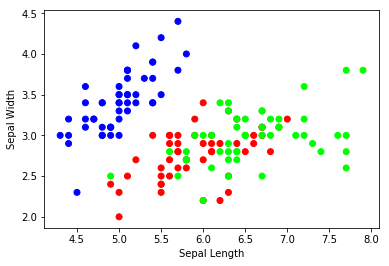

In [9]:
plt.scatter(iris_data[:, 0], iris_data[:, 1], c=species, cmap=plt.cm.brg)
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.show()

Next I import the `AgglomerativeClustering` object to perform hierarchical clustering, and then apply the method.

In [10]:
from sklearn.cluster import AgglomerativeClustering

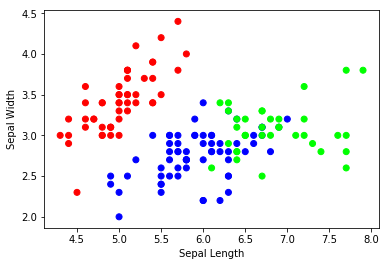

In [19]:
irisclust1 = AgglomerativeClustering(n_clusters=3,            # Three clusters
                                     affinity="euclidean",    # "Closeness" is defined using Euclidean distance
                                     linkage="average")       # A cluster's location is based on the average of its member points
irisclust1 = irisclust1.fit(iris_data)

# Visualizing the clustering
plt.scatter(iris_data[:, 0], iris_data[:, 1], c=irisclust1.labels_, cmap=plt.cm.brg)
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.show()

Choosing different affinity and linkage schemes yields different results.

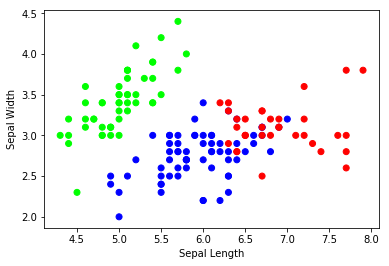

In [23]:
irisclust2 = AgglomerativeClustering(n_clusters=3,            # Three clusters with cluster centers chosen as random dataset
                                                              # points
                                     affinity="manhattan",    # "Closeness" is defined using Manhattan distance
                                     linkage="complete")      # A cluster's location is based on the maximum distance among
                                                              # member points
irisclust1 = irisclust2.fit(iris_data)

# Visualizing the clustering
plt.scatter(iris_data[:, 0], iris_data[:, 1], c=irisclust2.labels_, cmap=plt.cm.brg)
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.show()

Hierarchical clustering produces nice results but does not allow for "prediction". That is, it doesn't take new , never-before-seen datapoints and assign them to a cluster.

## Clustering Headlines

I now demonstrate clustering for the headlines dataset. Before, `AgglomerativeClustering` was generating an affinity matrix automatically using the specified distance metric. Now we provide it a precomputed affinity matrix to use. We will cluster the dataset into ten clusters.

In [24]:
headlineclust = AgglomerativeClustering(n_clusters=10, affinity="precomputed", linkage="average")
hclusters = headlineclust.fit_predict(1 - sims)    # Here we provide the affinity matrix; fit_predict() both fits and returns the
                                               # the assigned clusters
hclusters

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 5, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 9, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 8, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 6, 1, 4,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 3, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 0, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1,
       1], d

From here we may want to look at metrics such as the silhouette plot to assess the quality of the clustering.

In [25]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
%matplotlib inline

def silhouette_plot(data, labels, metric="euclidean", xticks = True):
    """Creates a silhouette plot given a dataset and the labels corresponding to cluster assignment, and reports the
       average silhouette score"""
    silhouette_avg = silhouette_score(data, labels,
                                      metric=metric)    # The average silhouette score over the entire sample
    sample_silhouette_values = silhouette_samples(data, labels,
                                                  metric=metric)    # The silhouette score of each individual data point
    
    # This loop creates the silhouettes in the silhouette plot
    y_lower = 10    # For space between silhouettes
    for k in np.unique(labels):
        cluster_values = sample_silhouette_values[labels == k]
        cluster_values.sort()
        nk = len(cluster_values)
        y_upper = y_lower + nk
        color = cm.spectral(float(k) / len(np.unique(labels)))
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_values,
                          facecolor=color, edgecolor=color)
        plt.text(-0.05, y_lower + 0.5 * nk, str(k))
        y_lower = y_upper + 10
    
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    if xticks:
        plt.xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.yticks([])
    plt.xlabel("Silhouette Score")
    plt.ylabel("Cluster")
    plt.show()
    
    print("The average silhouette score is", silhouette_avg)

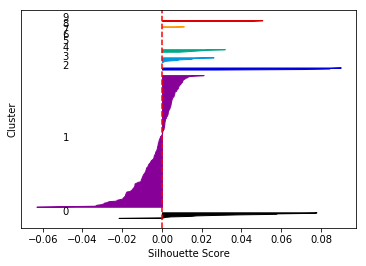

The average silhouette score is 0.000175100437834


In [26]:
silhouette_plot(1 - sims, hclusters, metric="precomputed", xticks=False)    # The silhouette plot requires a distance
                                                                            # matrix

In [ ]:
headlines[hclusters == 1]

This plot suggests that the clusters being produced are not particularly great. There is a megacluster that likely contains too many non-similar headlines and it should be broken up. (Negative numbers in silhouette plots, in general, are disturbing.) The good news, though, is that the clusters outside the megacluster are not necessarily bad clusters.